## Library

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
import time
import tempfile  # 추가
import s3fs
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime, timedelta
from scipy.stats import shapiro, spearmanr, kruskal
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')

## Load Data

In [3]:
s3 = s3fs.S3FileSystem()

years_reduced = list(range(2020, 2026))  # 2020 ~ 2025년
months_reduced = [f"s3://mlops-prj/data/weather/raw/year={year}/month={str(month).zfill(2)}"
                  for year in years_reduced for month in range(1, 13)]

# Parquet 파일 전체 경로 수집
all_files = []
for month_path in months_reduced:
    try:
        day_folders = s3.ls(month_path)  # 예: .../month=01/day=01 ...
        for day_folder in day_folders:
            files = s3.glob(f"{day_folder}/*.parquet")
            all_files.extend(files)
    except FileNotFoundError:
        continue  # 해당 월에 데이터 없으면 패스

print("전체 파일 개수:", len(all_files))

df_list = [pd.read_parquet(file, filesystem=s3) for file in all_files]
df = pd.concat(df_list, ignore_index=True)
df

In [4]:
# df.to_csv("../data/2020-2025.csv", index=False)
df = pd.read_csv("/content/drive/MyDrive/MLOps/data/2020-2025.csv")
df

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,GustTime,LocalPressure,SeaLevelPressure,PressureTrend,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
0,2020-01-01 00:00:00,108,0,0.0,-9,-9.0,-9,1022.6,1033.8,7,...,3.2,-9,-9.0,-9,4,1,0,2020,1,1
1,2020-01-01 01:00:00,108,5,1.7,-9,-9.0,-9,1021.8,1033.0,-9,...,3.2,-9,-9.0,-9,4,1,1,2020,1,1
2,2020-01-01 02:00:00,108,0,0.1,-9,-9.0,-9,1021.6,1032.8,-9,...,3.1,-9,-9.0,-9,4,1,2,2020,1,1
3,2020-01-01 03:00:00,108,0,0.0,-9,-9.0,-9,1021.5,1032.7,7,...,3.1,-9,-9.0,-9,4,1,3,2020,1,1
4,2020-01-01 04:00:00,108,0,0.0,-9,-9.0,-9,1021.6,1032.8,-9,...,3.0,-9,-9.0,-9,4,1,4,2020,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47506,2025-06-03 21:00:00,108,25,2.3,23,11.0,1511,990.5,1000.4,2,...,17.5,-9,-9.0,-9,3,2,21,2025,6,3
47507,2025-06-03 22:00:00,108,25,1.9,-9,-9.0,-9,991.2,1001.1,-9,...,17.7,-9,-9.0,-9,3,-9,22,2025,6,3
47508,2025-06-03 23:00:00,108,27,2.3,-9,-9.0,-9,991.3,1001.3,-9,...,20.8,-9,-9.0,-9,3,-9,23,2025,6,3
47509,2025-06-04 23:00:00,108,25,2.6,-9,-9.0,-9,998.1,1008.1,-9,...,18.2,-9,-9.0,-9,3,-9,23,2025,6,4


## Data Preprocessing

- Data Type Check
- Missing Value Check

In [5]:
df.describe()

,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,GustTime,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
count,47511.0,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,...,47511.000000,47511.0,47511.0,47511.0,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000,47511.000000
mean,108.0,18.404790,2.334573,-7.247943,-7.824841,68.349624,1005.673055,1015.918892,-4.621161,-6.001936,...,14.054141,-9.0,-9.0,-9.0,3.102924,-1.070531,11.502368,2022.232388,6.252068,15.708741
std,0.0,10.740649,1.189225,7.410340,4.777227,339.979739,16.821140,17.151445,6.373604,4.299276,...,9.574180,0.0,0.0,0.0,0.405516,4.675342,6.921546,1.578769,3.462057,8.810591
min,108.0,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,...,-99.000000,-9.0,-9.0,-9.0,-9.000000,-9.000000,0.000000,2020.000000,1.000000,1.000000
25%,108.0,7.000000,1.500000,-9.000000,-9.000000,-9.000000,999.500000,1009.400000,-9.000000,-9.000000,...,5.000000,-9.0,-9.0,-9.0,3.000000,-9.000000,6.000000,2021.000000,3.000000,8.000000
50%,108.0,23.000000,2.200000,-9.000000,-9.000000,-9.000000,1006.000000,1016.200000,-9.000000,-9.000000,...,14.800000,-9.0,-9.0,-9.0,3.000000,1.000000,12.000000,2022.000000,6.000000,16.000000
75%,108.0,27.000000,3.000000,-9.000000,-9.000000,-9.000000,1012.300000,1022.900000,2.000000,-0.800000,...,23.100000,-9.0,-9.0,-9.0,3.000000,2.000000,18.000000,2024.000000,9.000000,23.000000
max,108.0,36.000000,8.800000,36.000000,24.000000,2354.000000,1027.400000,1038.900000,8.000000,7.900000,...,30.600000,-9.0,-9.0,-9.0,4.000000,2.000000,23.000000,2025.000000,12.000000,31.000000


### Data Type Check

In [6]:
# Data type check
def check_dtype(df, return_data=False):
    object_df = df.select_dtypes(include=['object', 'category'])
    num_df = df.select_dtypes(include=['number'])

    print(f"Object Data Type: {object_df.shape[1]}")
    print(f"Number Data Type: {num_df.shape[1]}")

    if return_data: # 데이터 프레임 할당
        return object_df, num_df

In [7]:
str_df, num_df = check_dtype(df, return_data=True)

Object Data Type: 3
Number Data Type: 47


In [8]:
str_df

,ObservationTime,WeatherCode,CloudType
0,2020-01-01 00:00:00,05,Sc
1,2020-01-01 01:00:00,05,Sc
2,2020-01-01 02:00:00,05,Sc
3,2020-01-01 03:00:00,05,Sc
4,2020-01-01 04:00:00,05,Sc
...,...,...,...
47506,2025-06-03 21:00:00,-,-
47507,2025-06-03 22:00:00,-,-
47508,2025-06-03 23:00:00,-,-
47509,2025-06-04 23:00:00,-,-


In [9]:
num_df.columns

Index(['StationID', 'WindDirection', 'WindSpeed', 'GustDirection', 'GustSpeed',
       'GustTime', 'LocalPressure', 'SeaLevelPressure', 'PressureTrend',
       'PressureChange', 'Temperature', 'DewPointTemperature',
       'RelativeHumidity', 'VaporPressure', 'HourlyRainfall', 'DailyRainfall',
       'CumulativeRainfall', 'RainfallIntensity', 'SnowDepth3Hr',
       'DailySnowDepth', 'TotalSnowDepth', 'CurrentWeatherCode',
       'PastWeatherCode', 'TotalCloudCover', 'MidLowCloudCover',
       'LowestCloudHeight', 'UpperCloudType', 'MidCloudType', 'LowCloudType',
       'Visibility', 'SunshineDuration', 'SolarRadiation', 'GroundCondition',
       'GroundTemperature', 'SoilTemperature5cm', 'SoilTemperature10cm',
       'SoilTemperature20cm', 'SoilTemperature30cm', 'SeaCondition',
       'WaveHeight', 'MaxWindForce', 'PrecipitationData', 'ObservationType',
       'hour', 'year', 'month', 'day'],
      dtype='object')

In [10]:
# StationID 는 지점번호 를 의미 그래서 문자열로 변경
df['StationID'] = df['StationID'].astype(str)
df['year'] = df['year'].astype(int)
str_df, num_df = check_dtype(df, return_data=True) # 재할당

Object Data Type: 4
Number Data Type: 46


In [11]:
str_df.head()

,ObservationTime,StationID,WeatherCode,CloudType
0,2020-01-01 00:00:00,108,05,Sc
1,2020-01-01 01:00:00,108,05,Sc
2,2020-01-01 02:00:00,108,05,Sc
3,2020-01-01 03:00:00,108,05,Sc
4,2020-01-01 04:00:00,108,05,Sc


### Missing Value Check

In [12]:
df.isnull().sum().sum()

np.int64(0)

In [13]:
# -표시 확인
str_df.isin(['-']).sum()

,0
ObservationTime,0
StationID,0
WeatherCode,34604
CloudType,20825


In [14]:
cols_to_replace = ['CloudType', 'WeatherCode']
df[cols_to_replace] = df[cols_to_replace].replace('-', 'Other')
df.isin(['-']).sum().sum()

np.int64(0)

## EDA

- Normality Test
- Outlier

In [15]:
# 정규성 검토
def normality_test(df):
    df = df.select_dtypes(include=['number'])
    test_col = df.columns

    satisfied_cols = [] # 정규성 만족 컬럼
    unsatisfied_cols = [] # 정규성 불만족 컬럼

    for col in test_col:
        data = df[col]
        stat, p = shapiro(data)
        if p > 0.05:
            satisfied_cols.append(col)
        else:
            unsatisfied_cols.append(col)

    print(f"정규성 만족 컬럼 수: {len(satisfied_cols)}")
    print(f"정규성 불만족 컬럼 수: {len(unsatisfied_cols)}")
    return satisfied_cols, unsatisfied_cols

In [16]:
yes_norm, no_norm = normality_test(df)

print(f"\n정규성 만족 컬럼: {yes_norm}")

정규성 만족 컬럼 수: 4
정규성 불만족 컬럼 수: 42

정규성 만족 컬럼: ['GroundCondition', 'SeaCondition', 'WaveHeight', 'MaxWindForce']


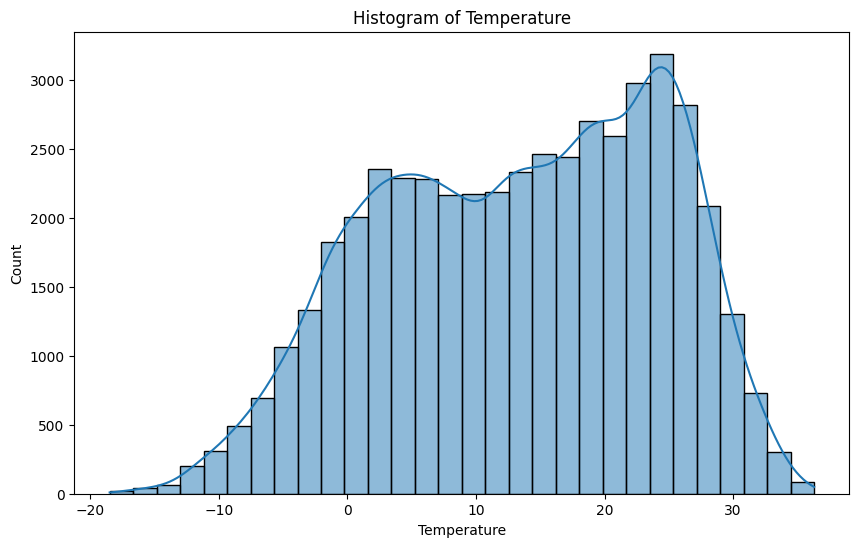

,Temperature
count,47511.000000
mean,13.396994
std,10.853668
min,-18.500000
25%,4.600000
50%,14.300000
75%,22.700000
max,36.300000


In [17]:
# target 변수 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(df['Temperature'], bins=30, kde=True)
plt.title('Histogram of Temperature')
plt.show()

df['Temperature'].describe()

### Outlier

In [18]:
# IQR기반 이상치
def outlier_iqr(df, threshold=1.5):
    df = df.select_dtypes(include=['number']).copy()
    outlier_summary = []

    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        ratio = round(len(outliers) / len(df) * 100, 3)

        outlier_summary.append({
            'Column': col,
            'Outlier Count': len(outliers),
            'Outlier Ratio (%)': ratio})

    return pd.DataFrame(outlier_summary).sort_values(by='Outlier Ratio (%)', ascending=False).reset_index(drop=True)

In [19]:
outiler_df = outlier_iqr(df)
outiler_df = outiler_df[outiler_df['Outlier Ratio (%)'] > 0]
outiler_df

,Column,Outlier Count,Outlier Ratio (%)
0,PastWeatherCode,11826,24.891
1,CurrentWeatherCode,11028,23.211
2,PrecipitationData,6538,13.761
3,Visibility,5381,11.326
4,HourlyRainfall,5337,11.233
5,GustSpeed,2731,5.748
6,GustTime,2731,5.748
7,GustDirection,2731,5.748
8,LowestCloudHeight,2325,4.894
9,TotalSnowDepth,2066,4.348


In [20]:
# 도메인 기반 컬럼 제외
outiler_cols = outiler_df['Column'].tolist()
remove_cols = ['PastWeatherCode', 'ObservationType', 'PrecipitationData', 'CurrentWeatherCode', 'GustTime']
outlier_cols = [col for col in outiler_cols if col not in remove_cols]

outlier_iqr(df[outlier_cols]) # 재확인

,Column,Outlier Count,Outlier Ratio (%)
0,Visibility,5381,11.326
1,HourlyRainfall,5337,11.233
2,GustSpeed,2731,5.748
3,GustDirection,2731,5.748
4,LowestCloudHeight,2325,4.894
5,TotalSnowDepth,2066,4.348
6,DailyRainfall,1980,4.167
7,CumulativeRainfall,1980,4.167
8,WindSpeed,925,1.947
9,DailySnowDepth,800,1.684


In [21]:
df[outlier_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Visibility,47511.0,1842.691545,870.747473,23.0,1317.0,2000.0,2000.0,5000.0
HourlyRainfall,47511.0,-7.824769,3.519385,-9.0,-9.0,-9.0,-9.0,64.7
GustSpeed,47511.0,-7.824841,4.777227,-9.0,-9.0,-9.0,-9.0,24.0
GustDirection,47511.0,-7.247943,7.410340,-9.0,-9.0,-9.0,-9.0,36.0
LowestCloudHeight,47511.0,3.585759,15.676464,-9.0,-9.0,3.0,10.0,77.0
TotalSnowDepth,47511.0,-8.510701,2.393588,-9.0,-9.0,-9.0,-9.0,28.6
DailyRainfall,47511.0,-4.316615,11.033616,-9.0,-9.0,-9.0,0.0,176.2
CumulativeRainfall,47511.0,-4.316615,11.033616,-9.0,-9.0,-9.0,0.0,176.2
WindSpeed,47511.0,2.334573,1.189225,-9.0,1.5,2.2,3.0,8.8
DailySnowDepth,47511.0,-8.811873,1.489008,-9.0,-9.0,-9.0,-9.0,19.3


In [22]:
# 음수값 확인
negative_cols = df.select_dtypes(include=['number']).columns[df.select_dtypes(include=['number']).lt(0).any()]
negative_cols

Index(['WindDirection', 'WindSpeed', 'GustDirection', 'GustSpeed', 'GustTime',
       'LocalPressure', 'SeaLevelPressure', 'PressureTrend', 'PressureChange',
       'Temperature', 'DewPointTemperature', 'HourlyRainfall', 'DailyRainfall',
       'CumulativeRainfall', 'RainfallIntensity', 'SnowDepth3Hr',
       'DailySnowDepth', 'TotalSnowDepth', 'CurrentWeatherCode',
       'PastWeatherCode', 'TotalCloudCover', 'MidLowCloudCover',
       'LowestCloudHeight', 'UpperCloudType', 'MidCloudType', 'LowCloudType',
       'SunshineDuration', 'SolarRadiation', 'GroundCondition',
       'GroundTemperature', 'SoilTemperature5cm', 'SoilTemperature10cm',
       'SoilTemperature20cm', 'SoilTemperature30cm', 'SeaCondition',
       'WaveHeight', 'MaxWindForce', 'PrecipitationData', 'ObservationType'],
      dtype='object')

In [23]:
# hist_plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None):
    plt.figure(figsize=figsize)

    # 개별 데이터 프레임
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None))

    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2')
        plt.legend()  # 두 그룹일 때만 범례 표시

    plt.title(title if title else f'{col} Distribution (Histogram + KDE)')
    plt.xlabel(col)
    plt.show()

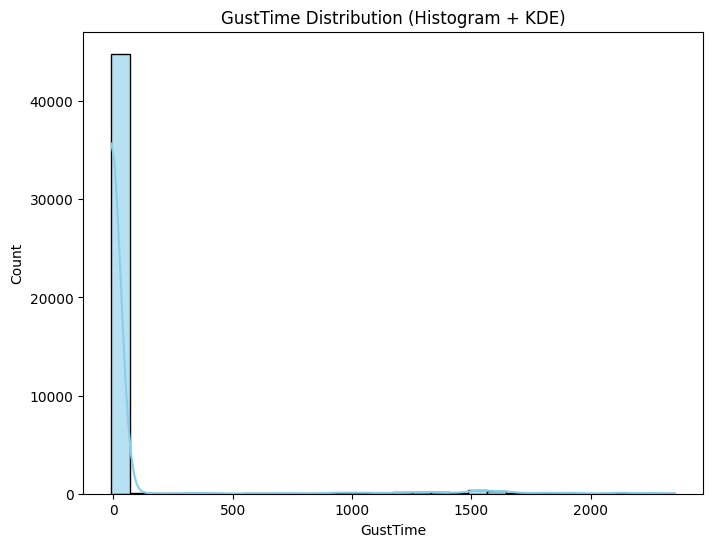

,GustTime
count,47511.000000
mean,68.349624
std,339.979739
min,-9.000000
25%,-9.000000
50%,-9.000000
75%,-9.000000
max,2354.000000


In [24]:
hist_plot(df, 'GustTime')
df[['GustTime']].describe()

In [25]:
impossible_minus_col = [
    'GustSpeed',           # 돌풍 속도: 속도이므로 음수 불가 (0은 바람 없음)
    'HourlyRainfall',      # 시간 강수량: 비의 양이므로 음수 불가 (0은 비 안 옴)
    'DailyRainfall',       # 일 강수량: 비의 양이므로 음수 불가
    'CumulativeRainfall',  # 누적 강수량: 비의 양이므로 음수 불가
    'RainfallIntensity',   # 강수 강도: 강수 세기이므로 음수 불가 (0은 비 안 옴)
    'SnowDepth3Hr',        # 3시간 적설: 눈의 깊이이므로 음수 불가 (0은 눈 안 쌓임)
    'DailySnowDepth',      # 일 적설: 눈의 깊이이므로 음수 불가
    'TotalSnowDepth',      # 총 적설: 눈의 깊이이므로 음수 불가
    'LowestCloudHeight',   # 최저 운고: 고도이므로 음수 불가 (0은 지표면 안개 등)
    'SunshineDuration',    # 일조 시간: 시간 값이므로 음수 불가 (0은 햇빛 없음)
    'SolarRadiation',      # 일사량: 에너지 양이므로 음수 불가 (0은 일사 없음)
    'WaveHeight',          # 파고: 파도의 높이이므로 음수 불가 (0은 파도 없음)
    'MaxWindForce'         # 최대 풍력: 풍력 값이므로 음수 불가
]

for col in impossible_minus_col:
    df[col] = df[col].apply(lambda x: 0 if x < 0 else x)

df[impossible_minus_col].describe().T

,count,mean,std,min,25%,50%,75%,max
GustSpeed,47511.0,0.657827,2.696842,0.0,0.0,0.00,0.00,24.00
HourlyRainfall,47511.0,0.164244,1.297983,0.0,0.0,0.00,0.00,64.70
DailyRainfall,47511.0,1.998407,8.918752,0.0,0.0,0.00,0.00,176.20
CumulativeRainfall,47511.0,1.998407,8.918752,0.0,0.0,0.00,0.00,176.20
RainfallIntensity,47511.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
SnowDepth3Hr,47511.0,0.004172,0.116027,0.0,0.0,0.00,0.00,9.80
DailySnowDepth,47511.0,0.036583,0.478294,0.0,0.0,0.00,0.00,19.30
TotalSnowDepth,47511.0,0.097937,0.820883,0.0,0.0,0.00,0.00,28.60
LowestCloudHeight,47511.0,7.879565,12.564853,0.0,0.0,3.00,10.00,77.00
SunshineDuration,47511.0,0.259361,0.403520,0.0,0.0,0.00,0.60,1.00


In [26]:
check_outiler = outlier_iqr(df)
check_outiler = check_outiler[check_outiler['Outlier Ratio (%)'] > 0]

outiler_cols = check_outiler['Column'].tolist()
remove_cols = ['PastWeatherCode', 'ObservationType', 'PrecipitationData', 'CurrentWeatherCode', 'GustTime']
outlier_cols = [col for col in outiler_cols if col not in remove_cols]

outlier_iqr(df[outlier_cols]) # 재확인

,Column,Outlier Count,Outlier Ratio (%)
0,CumulativeRainfall,9670,20.353
1,DailyRainfall,9670,20.353
2,Visibility,5381,11.326
3,LowestCloudHeight,4346,9.147
4,SolarRadiation,3460,7.283
5,HourlyRainfall,3008,6.331
6,GustSpeed,2731,5.748
7,GustDirection,2731,5.748
8,TotalSnowDepth,2046,4.306
9,WindSpeed,925,1.947


## Feature Engineering

- Spearman Test
- Kruskal-Wallis Test
- Scaler
- Encoding

### Spearman Test

In [27]:
def spearman_test(df, target_col):
    df_numeric = df.select_dtypes(include=['number'])
    features = []
    correlations = []
    p_values = []

    for col in df_numeric.columns:
        if col != target_col:
            corr, p = spearmanr(df_numeric[target_col], df_numeric[col])
            features.append(col)
            correlations.append(corr)
            p_values.append(p)

    corr_df = pd.DataFrame({
        'Feature': features,
        'Correlation': correlations,
        'P-value': p_values}).sort_values(by='Correlation', ascending=False).reset_index(drop=True)

    return corr_df

# heat_map
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])

        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

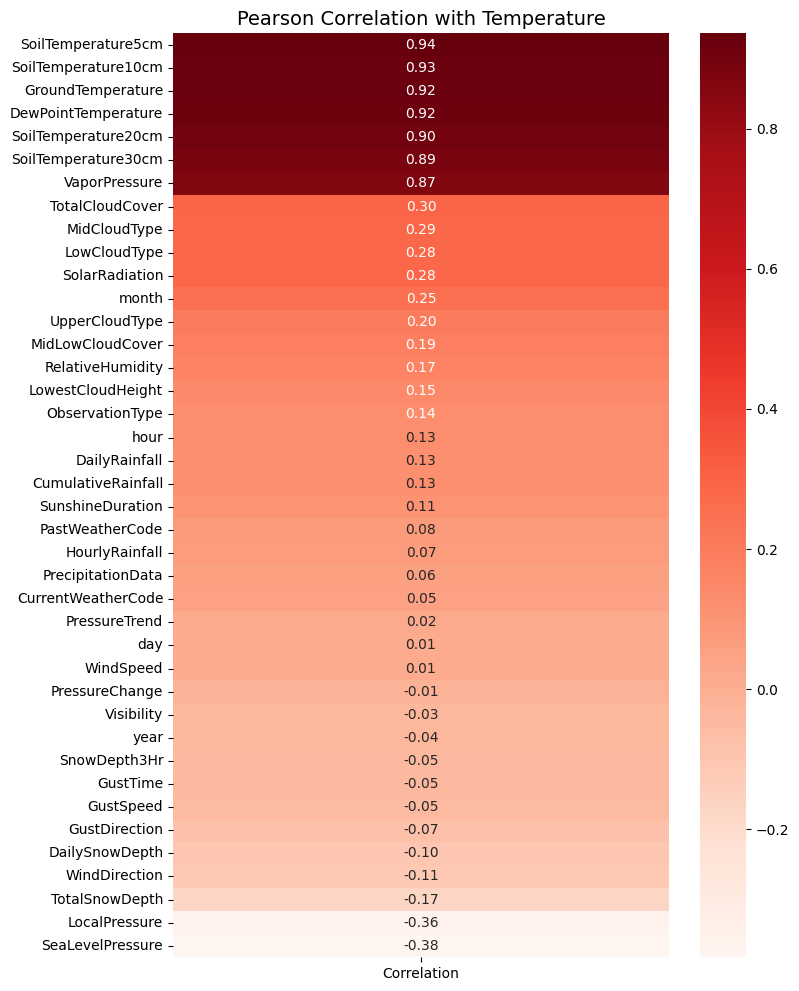

유의미하지 않은 변수의 수: 1
유의미한 변수의 수: 39


,Feature,Correlation,P-value
0,Visibility,0.007967,0.082482


In [28]:
heat_map(df, target_col='Temperature', figsize=(8, 12))
df_spearman = spearman_test(df, 'Temperature')

p_value_05 = df_spearman[df_spearman['P-value'] >= 0.05].reset_index(drop=True)
p_value_over_05 = df_spearman[df_spearman['P-value'] < 0.05].reset_index(drop=True)

print(f'유의미하지 않은 변수의 수: {len(p_value_05)}')
print(f'유의미한 변수의 수: {len(p_value_over_05)}')

p_value_05

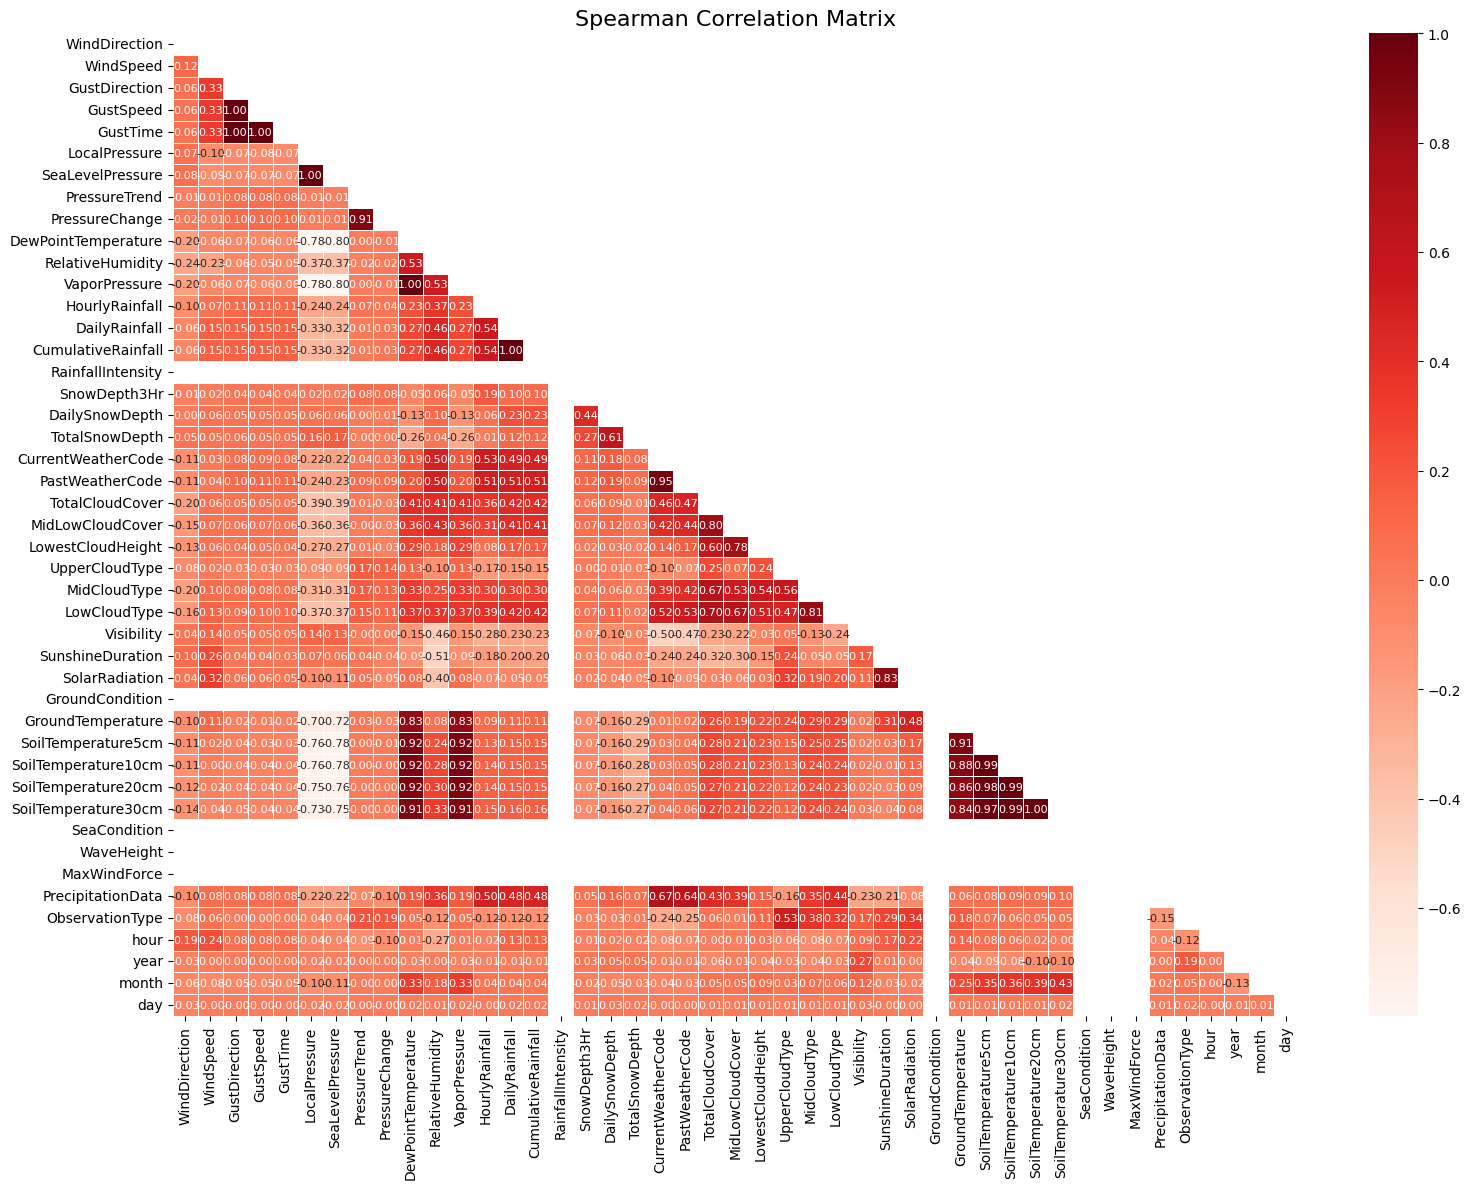

In [29]:
corr = df.select_dtypes(include=['number']).drop(columns=['Temperature']).corr(method='spearman')

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Reds', linewidths=0.5, mask=np.triu(corr), annot_kws={'size': 8})
plt.title("Spearman Correlation Matrix", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
def remove_high_corr_target(df, target_col, threshold=0.95, method='spearman'):
    feats = df.select_dtypes(include=[np.number]).columns.drop(target_col)
    corr_feats = df[feats].corr(method=method).abs()
    corr_target = df[feats].corrwith(df[target_col], method=method).abs()

    to_drop = set()
    for i, f1 in enumerate(feats):
        for f2 in feats[i+1:]:
            # 0.95 초과인 경우
            if corr_feats.loc[f1, f2] > threshold:
                if corr_target[f1] >= corr_target[f2]:
                    to_drop.add(f2)
                else:
                    to_drop.add(f1)
    return list(to_drop)

In [31]:
corr_drop_cols = remove_high_corr_target(df, target_col='Temperature', threshold=0.95, method='spearman')
print("서로 상관계수가 0.95 초과인 피처 수:", len(corr_drop_cols))
print("상관계수 0.95 초과인 피처:", corr_drop_cols)

서로 상관계수가 0.95 초과인 피처 수: 8
상관계수 0.95 초과인 피처: ['SoilTemperature30cm', 'CumulativeRainfall', 'SoilTemperature20cm', 'LocalPressure', 'GustTime', 'GustSpeed', 'DewPointTemperature', 'SoilTemperature10cm']


In [32]:
# 유의미하지 않은 변수 제거
p_value_05_cols = p_value_05['Feature'].tolist()
drop_cols = p_value_05_cols + ['GustTime']

df = df.drop(columns=drop_cols)
df

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
0,2020-01-01 00:00:00,108,0,0.0,-9,0.0,1022.6,1033.8,7,-1.4,...,3.2,-9,0,0,4,1,0,2020,1,1
1,2020-01-01 01:00:00,108,5,1.7,-9,0.0,1021.8,1033.0,-9,-9.0,...,3.2,-9,0,0,4,1,1,2020,1,1
2,2020-01-01 02:00:00,108,0,0.1,-9,0.0,1021.6,1032.8,-9,-9.0,...,3.1,-9,0,0,4,1,2,2020,1,1
3,2020-01-01 03:00:00,108,0,0.0,-9,0.0,1021.5,1032.7,7,-1.1,...,3.1,-9,0,0,4,1,3,2020,1,1
4,2020-01-01 04:00:00,108,0,0.0,-9,0.0,1021.6,1032.8,-9,-9.0,...,3.0,-9,0,0,4,1,4,2020,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47506,2025-06-03 21:00:00,108,25,2.3,23,11.0,990.5,1000.4,2,2.5,...,17.5,-9,0,0,3,2,21,2025,6,3
47507,2025-06-03 22:00:00,108,25,1.9,-9,0.0,991.2,1001.1,-9,-9.0,...,17.7,-9,0,0,3,-9,22,2025,6,3
47508,2025-06-03 23:00:00,108,27,2.3,-9,0.0,991.3,1001.3,-9,-9.0,...,20.8,-9,0,0,3,-9,23,2025,6,3
47509,2025-06-04 23:00:00,108,25,2.6,-9,0.0,998.1,1008.1,-9,-9.0,...,18.2,-9,0,0,3,-9,23,2025,6,4


### Derived Variable

In [33]:
def add_feature(df):
    # season
    df['season'] = df['month'].apply(lambda x:
        'Spring' if 3 <= x <= 5 else
        'Summer' if 6 <= x <= 8 else
        'Fall' if 9 <= x <= 11 else 'Winter')

    # time_segment
    df['time_segment'] = df['hour'].apply(lambda x:
        'Dawn' if 0 <= x < 6 else
        'Morning' if 6 <= x < 12 else
        'Afternoon' if 12 <= x < 18 else
        'Evening' if 18 <= x < 22 else
        'Night')

    return df

df = add_feature(df)
df.head()

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day,season,time_segment
0,2020-01-01 00:00:00,108,0,0.0,-9,0.0,1022.6,1033.8,7,-1.4,...,0,0,4,1,0,2020,1,1,Winter,Dawn
1,2020-01-01 01:00:00,108,5,1.7,-9,0.0,1021.8,1033.0,-9,-9.0,...,0,0,4,1,1,2020,1,1,Winter,Dawn
2,2020-01-01 02:00:00,108,0,0.1,-9,0.0,1021.6,1032.8,-9,-9.0,...,0,0,4,1,2,2020,1,1,Winter,Dawn
3,2020-01-01 03:00:00,108,0,0.0,-9,0.0,1021.5,1032.7,7,-1.1,...,0,0,4,1,3,2020,1,1,Winter,Dawn
4,2020-01-01 04:00:00,108,0,0.0,-9,0.0,1021.6,1032.8,-9,-9.0,...,0,0,4,1,4,2020,1,1,Winter,Dawn


### Kruskal-Wallis Test

In [34]:
def kruskal_test(df, target_col, min_group_size=5):
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    results = []

    for col in cat_cols:
        grouped = df.groupby(col)[target_col]
        valid_groups = [grp.values for _, grp in grouped if grp.size >= min_group_size]
        if len(valid_groups) >= 2:
            stat, p = kruskal(*valid_groups)
            results.append({'feature': col, 'H-statistic': stat, 'p-value': p})

    return pd.DataFrame(results).sort_values('p-value').reset_index(drop=True)

In [35]:
kruskal_df = kruskal_test(df, 'Temperature')
kruskal_df[kruskal_df['p-value'] < 0.05]

,feature,H-statistic,p-value
0,WeatherCode,3462.961845,0.0
1,CloudType,6166.536153,0.0
2,season,33202.411838,0.0
3,time_segment,1928.626771,0.0


In [36]:
df.columns

Index(['ObservationTime', 'StationID', 'WindDirection', 'WindSpeed',
       'GustDirection', 'GustSpeed', 'LocalPressure', 'SeaLevelPressure',
       'PressureTrend', 'PressureChange', 'Temperature', 'DewPointTemperature',
       'RelativeHumidity', 'VaporPressure', 'HourlyRainfall', 'DailyRainfall',
       'CumulativeRainfall', 'RainfallIntensity', 'SnowDepth3Hr',
       'DailySnowDepth', 'TotalSnowDepth', 'CurrentWeatherCode',
       'PastWeatherCode', 'WeatherCode', 'TotalCloudCover', 'MidLowCloudCover',
       'LowestCloudHeight', 'CloudType', 'UpperCloudType', 'MidCloudType',
       'LowCloudType', 'SunshineDuration', 'SolarRadiation', 'GroundCondition',
       'GroundTemperature', 'SoilTemperature5cm', 'SoilTemperature10cm',
       'SoilTemperature20cm', 'SoilTemperature30cm', 'SeaCondition',
       'WaveHeight', 'MaxWindForce', 'PrecipitationData', 'ObservationType',
       'hour', 'year', 'month', 'day', 'season', 'time_segment'],
      dtype='object')

In [37]:
# 날씨 코드 'WeatherCode', 지점번호 'StationID', 관측시간 'ObservationTime' 제거
df = df.drop(columns=['WeatherCode', 'StationID', 'ObservationTime', 'CurrentWeatherCode', 'PastWeatherCode'])

# 컬럼 순서 변경
df = df[['year', 'month', 'day', 'hour', 'Temperature'] + [c for c in df if c not in ['year', 'month', 'day', 'hour', 'Temperature']]]
df

,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,...,SoilTemperature10cm,SoilTemperature20cm,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,season,time_segment
0,2020,1,1,0,-6.5,0,0.0,-9,0.0,1022.6,...,0.7,2.1,3.2,-9,0,0,4,1,Winter,Dawn
1,2020,1,1,1,-5.9,5,1.7,-9,0.0,1021.8,...,0.7,2.1,3.2,-9,0,0,4,1,Winter,Dawn
2,2020,1,1,2,-5.7,0,0.1,-9,0.0,1021.6,...,0.6,2.0,3.1,-9,0,0,4,1,Winter,Dawn
3,2020,1,1,3,-5.6,0,0.0,-9,0.0,1021.5,...,0.6,2.0,3.1,-9,0,0,4,1,Winter,Dawn
4,2020,1,1,4,-5.4,0,0.0,-9,0.0,1021.6,...,0.6,2.0,3.0,-9,0,0,4,1,Winter,Dawn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47506,2025,6,3,21,19.2,25,2.3,23,11.0,990.5,...,21.6,19.2,17.5,-9,0,0,3,2,Summer,Evening
47507,2025,6,3,22,18.3,25,1.9,-9,0.0,991.2,...,20.9,19.2,17.7,-9,0,0,3,-9,Summer,Night
47508,2025,6,3,23,17.5,27,2.3,-9,0.0,991.3,...,21.6,21.9,20.8,-9,0,0,3,-9,Summer,Night
47509,2025,6,4,23,19.2,25,2.6,-9,0.0,998.1,...,20.8,19.6,18.2,-9,0,0,3,-9,Summer,Night


### sin, cos

In [38]:
df[['year', 'month', 'day', 'hour', 'Temperature']].describe().T

,count,mean,std,min,25%,50%,75%,max
year,47511.0,2022.232388,1.578769,2020.0,2021.0,2022.0,2024.0,2025.0
month,47511.0,6.252068,3.462057,1.0,3.0,6.0,9.0,12.0
day,47511.0,15.708741,8.810591,1.0,8.0,16.0,23.0,31.0
hour,47511.0,11.502368,6.921546,0.0,6.0,12.0,18.0,23.0
Temperature,47511.0,13.396994,10.853668,-18.5,4.6,14.3,22.7,36.3


In [39]:
# Hour (0-23)
max_hour = 23
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / (max_hour + 1))
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / (max_hour + 1))

# Month (1-12)
max_month = 12
df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / max_month)
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / max_month)

# Day (1-31)
max_day = 31
df['day_sin'] = np.sin(2 * np.pi * (df['day'] - 1) / max_day)
df['day_cos'] = np.cos(2 * np.pi * (df['day'] - 1) / max_day)

# check
df[['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']].head()

,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos
0,0.000000,1.000000,0.0,1.0,0.0,1.0
1,0.258819,0.965926,0.0,1.0,0.0,1.0
2,0.500000,0.866025,0.0,1.0,0.0,1.0
3,0.707107,0.707107,0.0,1.0,0.0,1.0
4,0.866025,0.500000,0.0,1.0,0.0,1.0


### Split Data

In [40]:
HORIZON = 168  # 예측하려는 미래 7일/일주일 (168시간)
SEQ_LEN = 336  # 입력 시퀀스: 과거 14일

df = df.sort_values(by=['year', 'month', 'day', 'hour']).reset_index(drop=True)
val_total_len = SEQ_LEN + HORIZON
val_df = df.iloc[-val_total_len:].copy()
train_df = df.iloc[:-val_total_len].copy()
latest_input = df.iloc[-SEQ_LEN:].copy()

print(f"train_df: {train_df.shape}")
print(f"val_df: {val_df.shape}")
print(f"latest_input: {latest_input.shape}")
train_df.head()

train_df: (47007, 51)
val_df: (504, 51)
latest_input: (336, 51)


,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,...,PrecipitationData,ObservationType,season,time_segment,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos
0,2020,1,1,0,-6.5,0,0.0,-9,0.0,1022.6,...,4,1,Winter,Dawn,0.000000,1.000000,0.0,1.0,0.0,1.0
1,2020,1,1,1,-5.9,5,1.7,-9,0.0,1021.8,...,4,1,Winter,Dawn,0.258819,0.965926,0.0,1.0,0.0,1.0
2,2020,1,1,2,-5.7,0,0.1,-9,0.0,1021.6,...,4,1,Winter,Dawn,0.500000,0.866025,0.0,1.0,0.0,1.0
3,2020,1,1,3,-5.6,0,0.0,-9,0.0,1021.5,...,4,1,Winter,Dawn,0.707107,0.707107,0.0,1.0,0.0,1.0
4,2020,1,1,4,-5.4,0,0.0,-9,0.0,1021.6,...,4,1,Winter,Dawn,0.866025,0.500000,0.0,1.0,0.0,1.0


### Scaler

In [41]:
train = train_df.copy().drop(columns=['year', 'month', 'day', 'hour'])
val   = val_df.copy().drop(columns=['year', 'month', 'day', 'hour'])
latest= latest_input.copy().drop(columns=['year', 'month', 'day', 'hour'])
num_cols = train.select_dtypes(include=['number']).drop(columns=['Temperature']).columns

scaler = RobustScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
val[num_cols] = scaler.transform(val[num_cols])
latest[num_cols] = scaler.transform(latest[num_cols])

latest.head()

,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,DewPointTemperature,...,PrecipitationData,ObservationType,season,time_segment,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos
47175,23.7,0.10,-0.133333,0.0,0.0,-0.578125,-0.577778,0.000000,0.000000,0.771574,...,0.0,-0.909091,Spring,Dawn,0.353553,6.123724e-01,0.633975,-0.366025,-0.545518,-0.38782
47176,23.6,-0.15,-0.800000,0.0,0.0,-0.625000,-0.622222,1.545455,1.073171,0.766497,...,0.0,0.000000,Spring,Dawn,0.500000,5.000000e-01,0.633975,-0.366025,-0.545518,-0.38782
47177,23.4,0.55,-1.133333,0.0,0.0,-0.648438,-0.644444,0.000000,0.000000,0.756345,...,0.0,0.090909,Spring,Dawn,0.612372,3.535534e-01,0.633975,-0.366025,-0.545518,-0.38782
47178,23.1,0.20,-0.066667,0.0,0.0,-0.617188,-0.614815,0.000000,0.000000,0.751269,...,0.0,0.090909,Spring,Dawn,0.683013,1.830127e-01,0.633975,-0.366025,-0.545518,-0.38782
47179,23.0,0.10,-0.400000,0.0,0.0,-0.632813,-0.629630,1.272727,1.085366,0.736041,...,0.0,0.090909,Spring,Morning,0.707107,1.731912e-16,0.633975,-0.366025,-0.545518,-0.38782


### Encoding

In [42]:
str_df, num_df = check_dtype(df ,return_data=True)

for col in str_df.columns:
    print(f"{col}의 유니크 수: {str_df[col].nunique()}")

Object Data Type: 3
Number Data Type: 48
CloudType의 유니크 수: 60
season의 유니크 수: 4
time_segment의 유니크 수: 5


In [43]:
str_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

label_cols = []
onehot_cols = []

for col in str_cols:
    unique_vals = train[col].nunique()
    if unique_vals <= 10:
        onehot_cols.append(col)
    else:
        label_cols.append(col)

label_encoders = {}
onehot_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le

    val[col] = val[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1) # val 처리
    latest[col] = latest[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1) # latest_input 처리

for col in onehot_cols:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    train_arr = ohe.fit_transform(train[[col]])
    ohe_cols = ohe.get_feature_names_out([col])

    # train 처리
    train_ohe = pd.DataFrame(train_arr, columns=ohe_cols, index=train.index)
    train.drop(columns=[col], inplace=True)
    train = pd.concat([train, train_ohe], axis=1)

    # val 처리
    val_arr = ohe.transform(val[[col]])
    val_ohe = pd.DataFrame(val_arr, columns=ohe_cols, index=val.index)
    val.drop(columns=[col], inplace=True)
    val = pd.concat([val, val_ohe], axis=1)

    # latest_input 처리
    latest_input_arr = ohe.transform(latest[[col]])
    latest_input_ohe = pd.DataFrame(latest_input_arr, columns=ohe_cols, index=latest.index)
    latest.drop(columns=[col], inplace=True)
    latest = pd.concat([latest, latest_input_ohe], axis=1)
    onehot_encoders[col] = ohe

print(f"train: {train.shape}")
print(f"val: {val.shape}")
print(f"latest: {latest.shape}")

train: (47007, 54)
val: (504, 54)
latest: (336, 54)


In [44]:
def check_column_order(X_train, X_val, X_train_name='X_train', X_val_name='X_val'):
    if X_train.columns.tolist() == X_val.columns.tolist():
        print(f"{X_train_name}과 {X_val_name}의 컬럼 및 순서가 모두 일치")
    else:
        print(f"{X_train_name}과 {X_val_name}의 컬럼 또는 순서 불일치")

        train_cols_set = set(X_train.columns)
        val_cols_set = set(X_val.columns)

        only_in_train = list(train_cols_set - val_cols_set)
        only_in_val = list(val_cols_set - train_cols_set)

        if only_in_train or only_in_val:
            print("컬럼 이름 불일치:")
            print(f"{X_train_name}에만 있는 컬럼:", only_in_train)
            print(f"{X_val_name}에만 있는 컬럼:", only_in_val)
        else:
            print("컬럼 이름은 동일하나 순서가 다름\n")

            for i, (col_train, col_val) in enumerate(zip(X_train.columns, X_val.columns)):
                if col_train != col_val:
                    print(f"{i}번째 컬럼 순서 불일치: {X_train_name} = {col_train}, {X_val_name} = {col_val}")

check_column_order(train, val, 'train', 'val')
check_column_order(train, latest, 'train', 'latest')

train과 val의 컬럼 및 순서가 모두 일치
train과 latest의 컬럼 및 순서가 모두 일치


In [45]:
# # 컬럼 순서 통일
# val = val[train.columns]
# latest_input = latest_input[train.columns]
# check_column_order(train, val, 'train', 'val') # 재확인
# check_column_order(train, latest_input, 'train', 'latest_input') # 재확인

## Models

In [46]:
class TempDataset(Dataset):
    def __init__(self, df, label_col, horizon, seq_len):
        self.seq_len = seq_len
        self.horizon = horizon
        self.X = df.drop(columns=[label_col]).values.astype(np.float32)
        self.y = df[label_col].values.astype(np.float32)
        self.input_len = len(self.X) - seq_len - horizon + 1

    def __len__(self):
        return self.input_len

    def __getitem__(self, idx):
        X_seq = self.X[idx: idx + self.seq_len]
        y_seq = self.y[idx + self.seq_len: idx + self.seq_len + self.horizon]
        return torch.tensor(X_seq), torch.tensor(y_seq)


class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [B, seq_len, H]
        last_out = lstm_out[:, -1, :]  # [B, H]
        output = self.fc(last_out)     # [B, horizon]
        return output

class LSTMTrainer:
    def __init__(self, model, device, lr=0.001):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.train_losses = []
        self.val_losses = []

    def train(self, train_loader, val_loader, epochs, patience=10):
        best_loss = float('inf')
        wait = 0
        best_model = None

        for epoch in range(1, epochs + 1):
            self.model.train()
            train_loss = 0.0
            for X, y in train_loader:
                X, y = X.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                pred = self.model(X)
                loss = self.criterion(pred, y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)

            # Validation
            self.model.eval()
            val_loss = 0.0
            all_preds, all_labels = [], []
            with torch.no_grad():
                for Xv, yv in val_loader:
                    Xv, yv = Xv.to(self.device), yv.to(self.device)
                    pred = self.model(Xv)
                    loss = self.criterion(pred, yv)
                    val_loss += loss.item()
                    all_preds.extend(pred.cpu().numpy())
                    all_labels.extend(yv.cpu().numpy())
            val_loss /= len(val_loader)
            mse = mean_squared_error(all_labels, all_preds)
            rmse = np.sqrt(mse)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f}")

            # Early stopping
            if val_loss < best_loss:
                best_loss = val_loss
                best_model = self.model.state_dict()
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping triggered at epoch {epoch}.")
                    break

        if best_model is not None:
            self.model.load_state_dict(best_model)

    def predict(self, latest_seq):
        self.model.eval()
        with torch.no_grad():
            inp = torch.tensor(latest_seq, dtype=torch.float32).unsqueeze(0).to(self.device)  # [1, seq_len, input_size]
            output = self.model(inp)  # [1, horizon]
            return output.cpu().numpy().flatten()

In [47]:
# 파라미터 정의
HORIZON = 168 # 예측 7일치
SEQ_LEN = 336 # 입력 2주치
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더
train_loader = DataLoader(TempDataset(train, 'Temperature', HORIZON, SEQ_LEN), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TempDataset(val, 'Temperature', HORIZON, SEQ_LEN), batch_size=BATCH_SIZE, shuffle=False)

# 모델 초기화 및 학습
model = LSTM_Model(input_size=train.shape[1]-1, hidden_size=128, num_layers=2, output_size=HORIZON)
trainer = LSTMTrainer(model, DEVICE, lr=LR)
trainer.train(train_loader, val_loader, epochs=EPOCHS)

# 예측
latest_arr = latest.drop(columns=['Temperature']).values.astype(np.float32)
pred = trainer.predict(latest_arr)
pred = np.round(pred, 1)

# 예측 시점 생성
last_row = df[['year','month','day','hour']].iloc[-1]
last_time = pd.Timestamp(int(last_row.year), int(last_row.month), int(last_row.day), int(last_row.hour))
next_times = [last_time + pd.Timedelta(hours=i+1) for i in range(HORIZON)]

# 결과 생성
pred_df = pd.DataFrame({
    'year': [t.year for t in next_times],
    'month': [t.month for t in next_times],
    'day': [t.day for t in next_times],
    'hour': [t.hour for t in next_times],
    'day_of_week': [t.strftime('%A') for t in next_times],
    'pred_Temperature': pred
})
pred_df

[Epoch 1] Train Loss: 51.1048 | Val Loss: 20.9665 | RMSE: 4.5789
[Epoch 2] Train Loss: 19.0380 | Val Loss: 11.6088 | RMSE: 3.4072
[Epoch 3] Train Loss: 16.7770 | Val Loss: 11.3411 | RMSE: 3.3677
[Epoch 4] Train Loss: 10.8908 | Val Loss: 2.3519 | RMSE: 1.5336
[Epoch 5] Train Loss: 7.6123 | Val Loss: 3.1030 | RMSE: 1.7615
[Epoch 6] Train Loss: 5.6235 | Val Loss: 2.5286 | RMSE: 1.5902
[Epoch 7] Train Loss: 4.5963 | Val Loss: 2.4775 | RMSE: 1.5740
[Epoch 8] Train Loss: 3.8163 | Val Loss: 2.5157 | RMSE: 1.5861
[Epoch 9] Train Loss: 3.3289 | Val Loss: 3.0990 | RMSE: 1.7604
[Epoch 10] Train Loss: 2.9651 | Val Loss: 2.3256 | RMSE: 1.5250
[Epoch 11] Train Loss: 2.6867 | Val Loss: 3.2856 | RMSE: 1.8126
[Epoch 12] Train Loss: 2.4532 | Val Loss: 3.5537 | RMSE: 1.8851
[Epoch 13] Train Loss: 2.2745 | Val Loss: 3.6822 | RMSE: 1.9189
[Epoch 14] Train Loss: 2.1255 | Val Loss: 4.1664 | RMSE: 2.0412
[Epoch 15] Train Loss: 1.9974 | Val Loss: 6.7077 | RMSE: 2.5899
[Epoch 16] Train Loss: 1.9287 | Val Loss: 

,year,month,day,hour,day_of_week,pred_Temperature
0,2025,6,5,22,Thursday,17.000000
1,2025,6,5,23,Thursday,16.600000
2,2025,6,6,0,Friday,16.400000
3,2025,6,6,1,Friday,16.400000
4,2025,6,6,2,Friday,16.700001
...,...,...,...,...,...,...
163,2025,6,12,17,Thursday,19.299999
164,2025,6,12,18,Thursday,18.500000
165,2025,6,12,19,Thursday,17.900000
166,2025,6,12,20,Thursday,17.299999


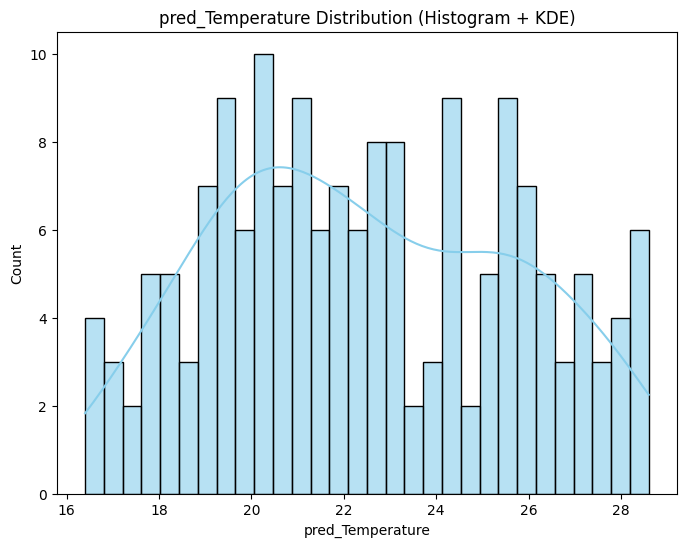

In [49]:
hist_plot(pred_df, 'pred_Temperature')

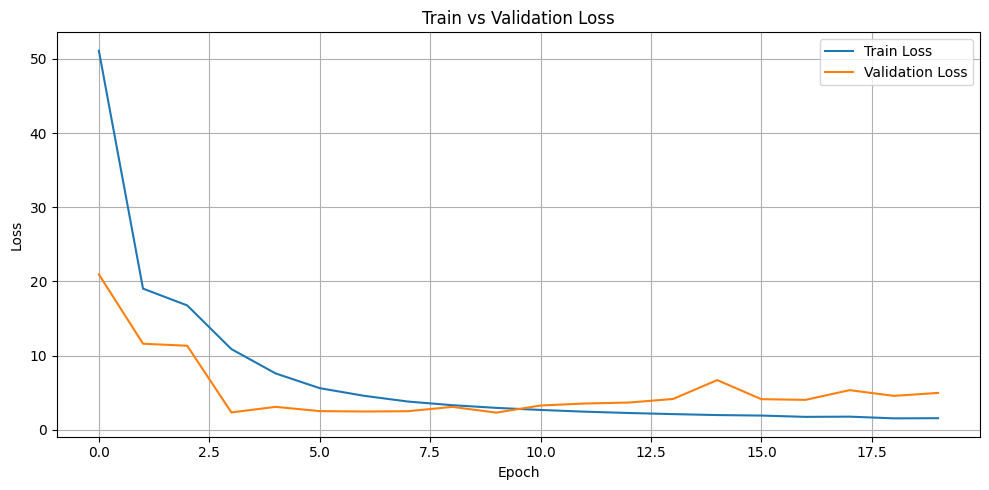

In [50]:
def plot_losses(trainer):
    plt.figure(figsize=(10, 5))
    plt.plot(trainer.train_losses, label='Train Loss')
    plt.plot(trainer.val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_losses(trainer)

## Inference Check

In [9]:
# path
train_path = 's3://mlops-prj/data/weather/feature/train/train_2025.06.09_1437.parquet'
val_path = 's3://mlops-prj/data/weather/feature/val/val_2025.06.09_1437.parquet'
latest_path = 's3://mlops-prj/data/weather/feature/latest/latest2025.06.09_1437.parquet'
pred_path = 's3://mlops-prj/data/weather/inference/forecast_20250609_1500.parquet'

s3 = s3fs.S3FileSystem()
train = pd.read_parquet(train_path, filesystem=s3)
val = pd.read_parquet(val_path, filesystem=s3)
latest = pd.read_parquet(latest_path, filesystem=s3)
pred = pd.read_parquet(pred_path, filesystem=s3)

print(f"Train Data: {train.shape}")
print(f"Val Data: {train.shape}")
print(f"Latest Data: {latest.shape}")
print(f"Predict Data: {pred.shape}")

Train Data: (47102, 53)
Val Data: (47102, 53)
Latest Data: (336, 53)
Predict Data: (168, 6)


<Axes: xlabel='hour'>

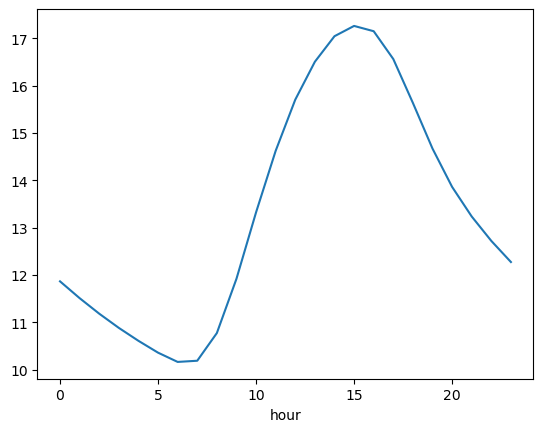

In [15]:
train.groupby("hour")["Temperature"].mean().plot()

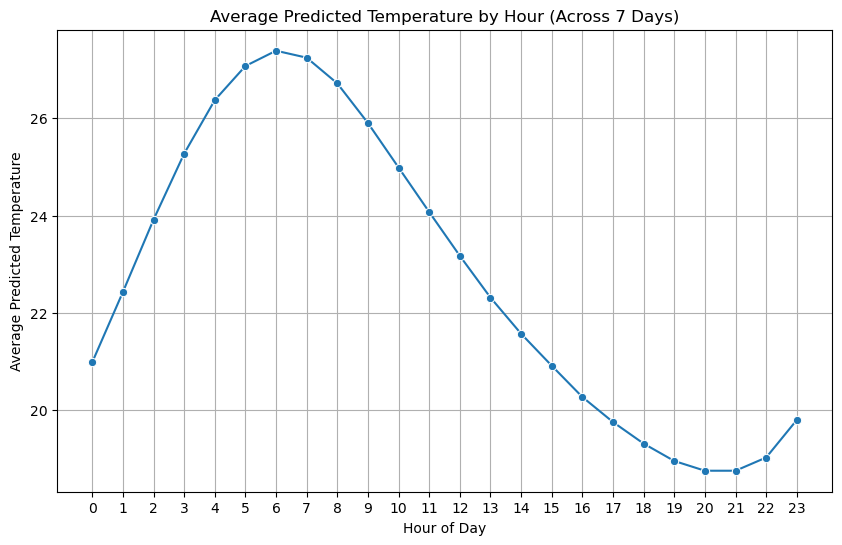

In [6]:
hourly_avg = pred.groupby('hour')['pred_Temperature'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_avg, x='hour', y='pred_Temperature', marker='o')
plt.title("Average Predicted Temperature by Hour (Across 7 Days)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Predicted Temperature")
plt.grid(True)
plt.xticks(range(0, 24))  # 0~23시
plt.show()